In [1]:
from fastai.vision.all import *
import torchaudio
from sklearn.model_selection import StratifiedKFold
import librosa
import kornia
from scipy import stats

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
df_train = pd.read_csv('/home/ubuntu/.kaggle/kaggle-pog-series-s01e02/train.csv')
df_test = pd.read_csv('/home/ubuntu/.kaggle/kaggle-pog-series-s01e02/test.csv')
submission = pd.read_csv('/home/ubuntu/.kaggle/kaggle-pog-series-s01e02/sample_submission.csv')

In [4]:
train_path = Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/')
test_path = Path('/home/ubuntu/.kaggle/spectrograms/spectograms/test/')
# train_path = Path('/home/ubuntu/.kaggle/rescale/spectograms/train/')
# test_path = Path('/home/ubuntu/.kaggle/rescale/spectograms/test/')

In [5]:
train_files = get_image_files(train_path)

In [6]:
train_files

(#19909) [Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/006638.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/000618.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/016641.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/023943.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/023478.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/016103.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/005110.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/023831.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/000200.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/007218.png')...]

In [7]:
def get_y(filename):
    resample_name = filename.stem + '.ogg'
    return df_train[df_train['filename']==resample_name]['genre'].values[0]

In [8]:
# Excluded unusual music thanks to this thread: https://www.kaggle.com/c/kaggle-pog-series-s01e02/discussion/312842
def get_items(path): 
    excluded_files = ["010449.png" , 
                      "005589.png" , 
                      "004921.png", 
                      "019511.png" , 
                      "013375.png" , 
                      "024247.png", 
                      "024156.png"]
    items = get_image_files(path)
    items = [item for item in items if item.name not in excluded_files]
    
    ## For fast iteration
#     items = [item for item in items if get_y(item) in ['Punk', 'Rock']]
    random.shuffle(items)
#     items.shuffle()
    return L(items)

In [9]:
# N_FFT = 2048
# HOP_LEN = 512

In [10]:
# def create_spectrogram(filename):
#     audio, sr = torchaudio.load(filename)
    
#     audio = audio.squeeze()
#     audio, index = librosa.effects.trim(audio, frame_length=1024, hop_length=256)  
#     audio = audio.unsqueeze(0)
        
#     specgram = torchaudio.transforms.MelSpectrogram(sample_rate=sr, 
#                                                     n_fft=N_FFT, 
#                                                     win_length=N_FFT, 
#                                                     hop_length=HOP_LEN,
#                                                     center=True,
#                                                     pad_mode="reflect",
#                                                     power=2.0,
#                                                     norm='slaney',
#                                                     onesided=True,
#                                                     n_mels=128,
#                                                     mel_scale="htk"
#                                                    )(audio)[0]
#     specgram = torchaudio.transforms.AmplitudeToDB()(specgram)
#     specgram = specgram - specgram.min()
#     specgram = specgram/specgram.max()*255
    
    
#     return specgram

In [11]:
# filename = train_files[0]
# spec_default = create_spectrogram(filename)

In [12]:
items = get_items(train_path)
labels = [get_y(item) for item in items]
count = Counter(labels)

In [13]:
test_items = get_items(test_path)

In [14]:
test_items

(#5076) [Path('/home/ubuntu/.kaggle/spectrograms/spectograms/test/000157.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/test/011703.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/test/004099.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/test/017496.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/test/015293.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/test/020178.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/test/009283.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/test/013417.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/test/018378.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/test/024413.png')...]

In [15]:
img = plt.imread(test_items[0])

In [16]:
img.shape

(224, 1293, 3)

In [17]:
# splitter = TrainTestSplitter(test_size=0.2, random_state=42, stratify=labels)

In [18]:
kf = StratifiedKFold(n_splits=7, shuffle=True)

In [19]:
splits_kfold=[]
for _, val_idx in kf.split(np.array(items), labels):
    splits = IndexSplitter(val_idx)
    split = splits(items)
    split_list = [split[0], split[1]]
    splits_kfold.append(split_list)

In [20]:
splits_kfold

[[(#17058) [0,1,2,3,4,5,6,7,8,9...],
  (#2844) [12,15,31,75,85,99,102,124,133,140...]],
 [(#17059) [1,2,3,4,9,11,12,13,14,15...],
  (#2843) [0,5,6,7,8,10,25,26,29,45...]],
 [(#17059) [0,1,3,4,5,6,7,8,9,10...],
  (#2843) [2,11,14,18,30,32,33,40,46,52...]],
 [(#17059) [0,2,3,4,5,6,7,8,9,10...],
  (#2843) [1,20,22,24,28,35,37,42,51,69...]],
 [(#17059) [0,1,2,3,5,6,7,8,9,10...],
  (#2843) [4,19,21,27,48,50,53,57,58,61...]],
 [(#17059) [0,1,2,3,4,5,6,7,8,10...],
  (#2843) [9,13,34,36,38,43,47,65,72,77...]],
 [(#17059) [0,1,2,4,5,6,7,8,9,10...],
  (#2843) [3,16,17,23,39,41,44,59,76,79...]]]

In [21]:
def alter_learner(learn, channels=1):
    learn.model[0][0][0].in_channels=channels
    learn.model[0][0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0][0].weight[:,1,:,:].unsqueeze(1))

In [22]:
def genreid_from_genre(genre):
    return int(genre2id[genre2id['genre'] == genre]['genre_id'].values[0])

In [23]:
splits_1fold = splits_kfold[0]

In [24]:
splits_kfold

[[(#17058) [0,1,2,3,4,5,6,7,8,9...],
  (#2844) [12,15,31,75,85,99,102,124,133,140...]],
 [(#17059) [1,2,3,4,9,11,12,13,14,15...],
  (#2843) [0,5,6,7,8,10,25,26,29,45...]],
 [(#17059) [0,1,3,4,5,6,7,8,9,10...],
  (#2843) [2,11,14,18,30,32,33,40,46,52...]],
 [(#17059) [0,2,3,4,5,6,7,8,9,10...],
  (#2843) [1,20,22,24,28,35,37,42,51,69...]],
 [(#17059) [0,1,2,3,5,6,7,8,9,10...],
  (#2843) [4,19,21,27,48,50,53,57,58,61...]],
 [(#17059) [0,1,2,3,4,5,6,7,8,10...],
  (#2843) [9,13,34,36,38,43,47,65,72,77...]],
 [(#17059) [0,1,2,4,5,6,7,8,9,10...],
  (#2843) [3,16,17,23,39,41,44,59,76,79...]]]

### Test Augmentation

In [25]:
# path = untar_data(URLs.PETS)

# test_imgs = get_image_files(path)

# TEST_IMAGE = test_imgs[4]

# img = PILImage(PILImage.create(TEST_IMAGE))


class ReflectionCrop(RandomCrop):
    def encodes(self, x:(Image.Image,TensorBBox,TensorPoint)):
        return x.crop_pad(self.size, self.tl, orig_sz=self.orig_sz, pad_mode=PadMode.Reflection)

# rsz = ReflectionCrop((375, 100))

# img2 = rsz(img, split_idx=0)

# img.shape

# img

In [26]:
items

(#19902) [Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/018077.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/002401.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/023117.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/010941.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/013164.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/005997.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/020891.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/011658.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/010410.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/024072.png')...]

In [27]:
splits_1fold

[(#17058) [0,1,2,3,4,5,6,7,8,9...],
 (#2844) [12,15,31,75,85,99,102,124,133,140...]]

In [28]:
class CustomDataBlock(DataBlock):
    def datasets(self:DataBlock, source, verbose=False, splits=None):
        self.source = source                     ; pv(f"Collecting items from {source}", verbose)
        items = (self.get_items or noop)(source) ; pv(f"Found {len(items)} items", verbose)
        pv(f"{len(splits)} datasets of sizes {','.join([str(len(s)) for s in splits])}", verbose)
        return Datasets(items, tfms=self._combine_type_tfms(), splits=splits, dl_type=self.dl_type, n_inp=self.n_inp, verbose=verbose)
    def dataloaders(self, source, path='.', verbose=False, splits=None, **kwargs):
        dsets = self.datasets(source, verbose=verbose, splits=splits)
        kwargs = {**self.dls_kwargs, **kwargs, 'verbose': verbose}
        return dsets.dataloaders(path=path, after_item=self.item_tfms, after_batch=self.batch_tfms, **kwargs)

In [29]:
def convert_MP_to_blurMP(model, layer_type_old):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_MP_to_blurMP(module, layer_type_old)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = kornia.contrib.MaxBlurPool2d(3, True)
            model._modules[name] = layer_new

    return model

In [30]:
def get_preds(splits_1fold, nb_epoch=42):
    
    db = CustomDataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_y=get_y,
        item_tfms=[ReflectionCrop(224)],
        batch_tfms=aug_transforms(max_rotate=0, max_warp=0,size=224))
    
    dls = db.dataloaders(items, splits=splits_1fold)
    
    mixup = MixUp(0.4)
    model = xse_resnext50(n_out=19, act_cls=Mish, sa=1, pool=MaxPool, pretrained=False)
    model = convert_MP_to_blurMP(model, nn.MaxPool2d)
    
    learn = Learner(dls, 
                    model, 
                    metrics=[accuracy, F1Score(average='micro')], 
                    loss_func=LabelSmoothingCrossEntropy(eps=0.15), 
                    opt_func=ranger, 
                   )
    
    learn.to_fp16()
    
#     nchannels = 1
#     alter_learner(learn, nchannels)
    
    learn.fit_flat_cos(nb_epoch, 0.002, cbs=[mixup, CSVLogger(fname=f'history_{int(time.time())}.csv'), ShowGraphCallback()])
    
#     test_dl = dls.test_dl(test_items)
#     preds = learn.get_preds(dl=test_dl)
    return None, learn


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.361840,2.195860,0.389944,0.389944,03:16


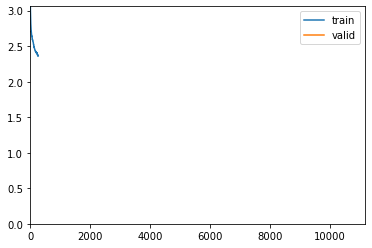

In [ ]:
preds_kfold_learns = []
for split_1fold in splits_kfold:
    preds_1fold_learns = get_preds(split_1fold)
    preds_kfold_learns.append(preds_1fold_learns)

In [ ]:
len(preds_kfold_learns)

In [ ]:
# _, learn = preds_kfold_learns[0]

In [ ]:
# test_dl = learn.dls.test_dl(test_items)

In [ ]:
# preds = learn.get_preds(dl=test_dl)

In [ ]:
_before_epoch = [event.before_fit, event.before_epoch]
_after_epoch  = [event.after_epoch, event.after_fit]

In [ ]:
@patch
def ttacustom(self:Learner, ds_idx=1, dl=None, n=4, item_tfms=None, batch_tfms=None, beta=0.25, use_max=False):
    "Return predictions on the `ds_idx` dataset or `dl` using Test Time Augmentation"
    if dl is None: dl = self.dls[ds_idx].new(shuffled=False, drop_last=False)
    if item_tfms is not None or batch_tfms is not None: dl = dl.new(after_item=item_tfms, after_batch=batch_tfms)
    try:
        self(_before_epoch)
        with dl.dataset.set_split_idx(0), self.no_mbar():
            if hasattr(self,'progress'): self.progress.mbar = master_bar(list(range(n)))
            aug_preds = []
            for i in self.progress.mbar if hasattr(self,'progress') else range(n):
                self.epoch = i #To keep track of progress on mbar since the progress callback will use self.epoch
                preds = self.get_preds(dl=dl, inner=True)[0][None]
                aug_preds.append(preds)
#                 preds_idx = preds.squeeze().argmax(1)
#                 aug_preds.append(preds_idx)
#         aug_preds = torch.cat(aug_preds)
#         aug_preds = aug_preds.max(0)[0] if use_max else aug_preds.mean(0)
#         self.epoch = n
#         with dl.dataset.set_split_idx(1): preds,targs = self.get_preds(dl=dl, inner=True)
    finally: self(event.after_fit)

#     if use_max: return torch.stack([preds, aug_preds], 0).max(0)[0],targs
#     preds = (aug_preds,preds) if beta is None else torch.lerp(aug_preds, preds, beta)
    return aug_preds

In [ ]:
# aug_preds = learn.ttacustom(dl=test_dl, n=2, beta=None)

In [ ]:
# aug_preds

In [ ]:
# preds_kfold = [pred_learn[0] for pred_learn in preds_kfold_learns]
learns = [pred_learn[1] for pred_learn in preds_kfold_learns]

### Test inference

In [ ]:
for i, learn in enumerate(learns):
    print(i)
    learn.export(f'learn_export_{i}.pkl')

### Finish test inference

In [57]:
learn.dls.after_item

Pipeline: ReflectionCrop -- {'size': (224, 224), 'p': 1.0} -> ToTensor

In [58]:
learn.dls.after_batch

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': 224, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}

In [59]:
IntToFloatTensor

fastai.data.transforms.IntToFloatTensor

In [77]:
aug_preds = []
for learn in learns:
    test_dl = learn.dls.test_dl(test_items)
    aug_preds_1fold = learn.ttacustom(dl=test_dl, n=20, beta=None, item_tfms=learn.dls.after_item, batch_tfms=IntToFloatTensor)
    aug_preds.extend(aug_preds_1fold)

KeyboardInterrupt: 

In [ ]:
# preds_kfold = [pred_learn[0][0] for pred_learn in preds_kfold_learns]
# preds_list = [pred.argmax(axis=1) for pred in preds_kfold]
# preds_array = np.array(preds_list)
# final_votes = preds_array[1]

In [ ]:
# preds_array[0]

In [ ]:
# aug_preds

In [ ]:
aug_preds

In [72]:
aug_preds_new = [aug_pred.squeeze().argmax(1) for aug_pred in aug_preds]

In [73]:
final_votes = stats.mode(torch.vstack(aug_preds_new))[0][0]

In [74]:
final_votes

array([ 6, 16,  7, ...,  2,  6, 10])

In [63]:
# preds_kfold = [pred_learn[0] for pred_learn in preds_kfold_learns]
# preds_kfold = [np.array(preds[0]) for preds in preds_kfold]
# preds_list = [pred.argmax(axis=1) for pred in preds_kfold]
# preds_array = np.array(preds_list)
# values, counts = np.unique(preds_array,axis=0, return_counts=True)
# Counter(preds_array[:,0]).most_common(1)[0][0]
# final_votes = [Counter(preds_array[:,i]).most_common(1)[0][0] for i in range(preds_array.shape[1])]
# final_preds = np.array(preds_kfold).mean(axis=0)

In [64]:
# final_votes = preds_array[0]

In [65]:
# submission[submission['song_id']=="024013"]

In [66]:
torch.vstack(aug_preds).shape

torch.Size([140, 5076, 19])

In [67]:
final_votes.shape

(5076, 19)

In [75]:
# preds_idx = final_preds.argmax(axis=1)
genre2id = pd.read_csv('/home/ubuntu/.kaggle/kaggle-pog-series-s01e02/genres.csv')
songid_preds = {int(file_path.stem):genreid_from_genre(learns[0].dls.vocab[_id]) for file_path, _id in zip(test_items,final_votes)}
submission['genre_id'] = submission['song_id'].map(songid_preds)
submission['genre_id'].fillna(0, inplace=True)
submission.loc[submission['song_id']==22612, 'genre_id'] = 1
submission.loc[submission['song_id']==24013, 'genre_id'] = 0

submission.genre_id = submission.genre_id.astype(int)
submission.to_csv(f"submission_final_{int(time.time())}.csv", index=False)

In [76]:
submission

,song_id,genre_id
0,7072,0
1,10207,12
2,20008,0
3,10924,0
4,21896,4
...,...,...
5073,6427,3
5074,16903,0
5075,1731,6
5076,12871,0
